In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import re
from pathlib import Path
from tqdm import tqdm
import json

# Step 1: Look at available Chinese dialog corpora

**CallFriend**
- available `/corpora/LDC/LDC96S55`
- `/corpora/LDC/LDC96S55/doc/spkrinfo.doc`

In [ ]:
%ls /corpora/LDC/LDC96S55/cf_man_m/evltest/

In [ ]:
%ls /corpora/LDC/LDC96S55/doc

In [ ]:
!head -n 20 /corpora/LDC/LDC96S55/doc/spkrinfo.doc

In [ ]:
%less /corpora/LDC/LDC96S55/doc/spkrinfo.tbl

In [ ]:
%cat /corpora/LDC/LDC96S55/doc/cf_man_m.doc

 **Notes** <br/>
 - Actually just audio files and descriptions
 - But it still has decent demographic information of speakers
 - it looks like [this](https://catalog.ldc.upenn.edu/LDC2018S18) is the version that includes transcripts: LDC2018S18
 

In [ ]:
%ls /corpora/LDC/ | grep 'LDC2018' 

It looks like LDC2018S18 corpus is not in UW's directory

In [ ]:
Brandon added it under /corpora/LDC/LDC2018S18

In [ ]:
%ls /corpora/LDC/LDC2018S18/data/transcripts/mandarin

In [ ]:
!head -n 10 /corpora/LDC/LDC2018S18/data/transcripts/mandarin/ma_4160.txt

See if you can get any more info on A and B speakers in ma_4160

In [ ]:
%ls /corpora/LDC/LDC2018S18/docs

In [ ]:
!cat /corpora/LDC/LDC2018S18/docs/spkrinfo.tbl

In [ ]:
#some interesting variables available in /corpora/LDC/LDC2018S18/docs/callinfo.tbl
!head -n 10 /corpora/LDC/LDC2018S18/docs/callinfo.tbl

Given that there is also some detail of the *caller* only in spkrinfo.tbl, I wonder if it would be possible to identify at least the caller in the spkrinfo.tbl file?

In [ ]:
!head -n 5 /corpora/LDC/LDC2018S18/docs/spkrinfo.tbl

In [ ]:
with open('/corpora/LDC/LDC2018S18/docs/callinfo.tbl','r') as infile:
    callfriend_raw = infile.read()

In [ ]:
#get counts of ages
all_ages = re.findall('(?<=age=).*?(?=\s)',callfriend_raw)
Counter(all_ages)

In [ ]:
#get counts of all sexes
all_sexes = re.findall('(?<=sex=)[M|F]',callfriend_raw)
Counter(all_sexes)

In [ ]:
#Find stuff in directories

p = Path('/corpora/LDC/LDC2018S18/data/transcripts/mandarin/')
files = [f for f in p.iterdir() if f.is_file()]


In [ ]:
ni_count = 0
nin_count = 0

for i in tqdm(range(0,len(files))):
    with open(str(files[i].absolute()),'r') as infile:
        raw = infile.read()
        
        ni_count += len(re.findall('你',raw))
        nin_count += len(re.findall('您',raw))
        
        if bool(re.findall('您',raw)):
            print(str(files[i].absolute()))

In [ ]:
print(f'{round(100*(nin_count/(nin_count+ni_count)),2)}% of "you"s are 您')
print(f'{nin_count} instances out of {nin_count+ni_count}')

In [ ]:
%less /corpora/LDC/LDC2018S18/data/transcripts/mandarin/ma_5930.txt

### Explore relations between CallFriend speakers

Question: how can I link the call ids to the speaker ids?

In [ ]:
!head -n 5 /corpora/LDC/LDC96S55/doc/callinfo.tbl

In [ ]:
!head -n 20  /corpora/LDC/LDC96S55/doc/spkrinfo.tbl

 For example: <br/> 
 ma_4160,M,30,22,Anhui,203778bah means: <br/>
- Call-ID = ma_4160
- Gender of caller = Male
- Age of caller = 30
- Years of education completed by caller = 22
- Where the caller grew up (typically a state name) = Anhui
- Area-code plus first three digits of telephone number dialed (last four digits of number are encrypted as three letters) = 203778bah <br/> <br/>
Note that there seem to be plenty of missing values

In [ ]:
%ls /corpora/LDC/LDC96S55/cf_man_m/devtest/

In [ ]:
!head -n 10 /corpora/LDC/LDC96S55/cf_man_m/devtest/ma_4559.sph

In [ ]:
%less /corpora/LDC/LDC96S55/doc/cf_man_m.doc

In [ ]:
with open('/corpora/LDC/LDC96S55/doc/callinfo.tbl','r') as infile:
    raw= infile.read().split('\n')

In [ ]:
import re
call_ids = [re.findall('ma_[0-9]*',item)[0] for item in raw if len(item)>0]
call_ids = sorted(call_ids)
len(call_ids)

In [ ]:
call_ids[0:5]

In [ ]:
with open('/corpora/LDC/LDC96S55/doc/spkrinfo.tbl','r') as infile:
    raw= infile.read().split('\n')
speaker_ids = [re.findall('ma_[0-9]*',item)[0] for item in raw if len(item)>0]
speaker_ids = sorted(speaker_ids)
len(speaker_ids)

In [ ]:
len(set(speaker_ids).intersection(set(call_ids)))

Actually the speaker ids and call ids are overlapping... how does that work? maybe the first id of the call table is actually speaker ids and the PINs are the call ids? That would imply duplicate PIN ids with 2 different ma_ numbers

In [ ]:
with open('/corpora/LDC/LDC96S55/doc/callinfo.tbl','r') as infile:
    raw= infile.read().split('\n')


In [ ]:
test = raw[0]
test

In [ ]:
PINs = [re.findall('(?<=PIN=)[0-9]*(?=|)',item)[0] for item in raw if len(item)>0]
len(PINs)

In [ ]:
len(set(PINs))

There are no duplicated PIN numbers either. My guess is that only demographics of the caller are recorded, and not the recipient. 

Trying **2005 NIST Speaker Recognition Evaluation Training Data** <br/>
- `/corpora/LDC/LDC11S01`

In [ ]:
%ls /corpora/LDC/LDC11S01/nist_2005_sre_tr_d1

In [ ]:
!head -n 5 /corpora/LDC/LDC11S01/nist_2005_sre_tr_d1/index.html

In [ ]:
%ls /corpora/LDC/LDC11S01/nist_2005_sre_tr_d1/data/

In [ ]:
!head -n 5 /corpora/LDC/LDC11S01/nist_2005_sre_tr_d1/data/asr_tran/jaab.ctm

In [ ]:
%less /corpora/LDC/LDC11S01/nist_2005_sre_tr_d1/doc/file.tbl

Trying **MAGICDATA Mandarin Chinese Conversational Speech Corpus: MDT2021S003** <br/>
- https://www.openslr.org/123/

In [ ]:
%ls MDT2021S003/

In [ ]:
!head -n 5 MDT2021S003/SPKINFO.txt

In [ ]:
import pandas as pd
with open('MDT2021S003/SPKINFO.txt','r') as infile:
    df = pd.read_table(infile)
df.head(5)

In [ ]:
from collections import Counter
Counter(df.AGE)

In [ ]:
Counter(df.GENDER)

Problem with this data: very little demographic information available for speakers.

Trying **HKUST/MTS: A Very Large Scale Mandarin
Telephone Speech Corpus** <br/>
- https://www.researchgate.net/profile/David-Graff-5/publication/220758477_HKUSTMTS_A_very_large_scale_Mandarin_telephone_speech_corpus/links/004635346a94cf2642000000/HKUST-MTS-A-very-large-scale-Mandarin-telephone-speech-corpus.pdf
- LDC2005T32
- Not downloaded on Patas, but says it's installed [here](https://cldb.ling.washington.edu/live/livesearch-corpus-form.php)

In [ ]:
%ls /corpora/LDC/ | grep 'LDC200' 

According to Brandon, this is under `/corpora/LDC/LDC05T32`

In [ ]:
%ls /corpora/LDC/LDC05T32/docs

In [ ]:
!head -n 5 /corpora/LDC/LDC05T32/docs/calldata-train.txt

In [ ]:
%less /corpora/LDC/LDC05T32/docs/file.tbl

Interesting **notes** from readme: <br/>
- Most subjects did not previously know each other.
- Topics were proposed to subjects
- Subjects were asked to provide several pieces of demographic
information, including gender, age, native language/dialect,
birthplace, education, occupation, phone type, etc.

In [ ]:
%ls /corpora/LDC/LDC05T32/data/trans/train

Do some exploratory statistics on the demographics of training data

In [ ]:

with open('/corpora/LDC/LDC05T32/docs/calldata-train.txt','r') as infile:
    demographics = pd.read_table(infile)

In [ ]:
demographics.head(5)

In [ ]:
#rename all columns to have underscores instead of spaces
original_cols = list(demographics.columns)
new_cols = [re.sub(' ','_',item) if ' ' in item else item for item in list(demographics.columns)]

change_cols = dict()
for i in range(0,len(original_cols)):
    change_cols[original_cols[i]] = new_cols[i]
demographics = demographics.rename(columns=change_cols)
demographics.columns

In [ ]:
#Get a histogram of ages of callers in buckets of decades
all_ages = list(demographics.Age_A)+list(demographics.Age_B)
sorted(Counter(all_ages).items())


In [ ]:
print(max(Counter(all_ages).keys()))
print(min(Counter(all_ages).keys()))

In [ ]:
def get_decade(a)->str:
    output = ''
    if a< 10:
        output += '0s'
    elif a <20:
        output += '10s'
    elif a <30:
        output += '20s'
    elif a <40:
        output += '30s'
    elif a <50:
        output += '40s'
    elif a <60:
        output += '50s'
    elif a <70:
        output += '60s'  
    return output

In [ ]:
demographics['decade_A'] = demographics.Age_A.apply(get_decade)
demographics['decade_B'] = demographics.Age_B.apply(get_decade)

In [ ]:
demographics.head(5)

In [ ]:
#graph a sorted histogram of decades
all_decades = list(demographics.decade_A)+list(demographics.decade_B)

plt.bar(Counter(all_decades).keys(),Counter(all_decades).values())
plt.suptitle("Distribution of ages of caller participants")

In [ ]:
#graph sorted pairs of participants to conversations

age_of_call = []
for i in range(0,len(demographics)):
    
    a = demographics.decade_A.iloc[i]
    b = demographics.decade_B.iloc[i]
    
    pair = sorted([a,b])
    age_of_call.append(pair[0]+' and '+pair[1])


In [ ]:
age_pairs = Counter(age_of_call).most_common()

In [ ]:
plt.bar([item[0] for item in age_pairs],[item[1] for item in age_pairs])
plt.suptitle("Distribution of ages pairs")
plt.xticks(rotation=90)

**notes**
- most calls are among people in their 20s
- most calls are between people both of whom are in their 20s

In [ ]:
#Get distributions of topics discussed
with open('/corpora/LDC/LDC05T32/docs/topic-list.txt','r') as infile:
    topics_raw = infile.read()

In [ ]:
%less /corpora/LDC/LDC05T32/docs/topic-list.txt

In [ ]:
raw_list = re.findall('[0-9]{1,2}\..*(?=\n)',topics_raw)
topic_dict = Counter()
for row in raw_list:
    topic_key = int(re.findall('[0-9]*(?=\.)',row)[0])
    topic = re.findall('(?<=[0-9]\. ).*',row)[0]
    topic_dict[topic_key]=topic
    
topic_dict

In [ ]:
def index_to_topic(a:int) -> str:
    
    return(topic_dict[a])


In [ ]:
demographics['Topic_Name'] = demographics.Topic_ID.apply(index_to_topic)

In [ ]:
Counter(demographics.Topic_Name).most_common()

In [ ]:
#get a simple distribution of 你 and 您 across training data

In [ ]:
%ls /corpora/LDC/LDC05T32/data/trans/train/

In [ ]:
!head -n 5 /corpora/LDC/LDC05T32/data/trans/train/20040527_210939_A901153_B901154.txt

In [ ]:
!file /corpora/LDC/LDC05T32/data/trans/train/20040527_210939_A901153_B901154.txt

Important lesson learned from [this thread](https://stackoverflow.com/questions/23731176/how-to-print-chinese-characters-stored-in-a-file-with-charset-iso-8859-1-in-py): "file is probably wrong, since it only 'guesses' the encoding. Using gb18030 as the encoding gives the correct result"

In [ ]:
with open('/corpora/LDC/LDC05T32/data/trans/train/20040527_210939_A901153_B901154.txt','r',encoding='iso-8859-1') as infile:
    raw = infile.read()

In [ ]:
with open('/corpora/LDC/LDC05T32/data/trans/train/20040527_210939_A901153_B901154.txt','r',encoding='gb18030') as infile:
    raw = infile.read()

In [ ]:
#Find stuff in directories

p = Path('/corpora/LDC/LDC05T32/data/trans/train/')
files = [f for f in p.iterdir() if f.is_file()]


In [ ]:
ni_count = 0
nin_count = 0

for i in tqdm(range(0,len(files))):
    with open(str(files[i].absolute()),'r',encoding='gb18030') as infile:
        raw = infile.read()
        
        ni_count += len(re.findall('你',raw))
        nin_count += len(re.findall('您',raw))
        

In [ ]:
print(f'{round(100*(nin_count/(nin_count+ni_count)),2)}% of "you"s are 您')
print(f'{nin_count} instances out of {nin_count+ni_count}')

Trying **CallHome**
- /corpora/LDC/LDC96S34 

In [ ]:
%ls /corpora/LDC/LDC96S34

In [ ]:
!less /corpora/LDC/LDC96S34/0readme.1st

In [ ]:
%ls /corpora/LDC/LDC96T16

Trying **CRECIL**
- [paper](http://www.lrec-conf.org/proceedings/lrec2022/pdf/2022.lrec-1.250.pdf)
- [Github](https://github.com/bistu-nlp-lab/CRECIL)

In [7]:
%ls ../CRECIL/My_home_data

exportCRT.py  final.json


In [7]:
%less ../CRECIL/Final_Data/train.json

In [2]:
with open('../CRECIL/Final_Data/train.json','r') as infile:
    train_df = json.loads(infile.read())

Something just dawning on me now: in the transcript with multiple people, it's not super clear who each line is being directed _at_. This is a problem, because that's the signal that I'm hoping will tell me how formality is being used. However it seems like this is equality important for relation extraction, so I can learn how the baseline/other approaches resolve this. 

In [3]:
ni_count = 0
nin_count = 0

for i in tqdm(range(0,len(train_df))):

    raw_list = train_df[i][0]
    for raw in raw_list:

        ni_count += len(re.findall('你',raw))
        nin_count += len(re.findall('您',raw))


100%|██████████████████████████████████████| 482/482 [00:00<00:00, 27232.07it/s]


In [4]:
print(f'{round(100*(nin_count/(nin_count+ni_count)),2)}% of "you"s are 您')
print(f'{nin_count} instances out of {nin_count+ni_count}')

28.39% of "you"s are 您
2800 instances out of 9863


In [5]:
with open('../CRECIL/Final_Data/test.json','r') as infile:
    test_df = json.loads(infile.read())

In [6]:
with open('../CRECIL/My_home_data/final.json','r') as infile:
    final_df = json.loads(infile.read())
    

In [13]:
final_df[0][0]

['S 1: 爸，动画片儿哪频道啊？',
 'S 2: 看哪门子动画片呀----看连续剧',
 'S 3: 小张你这菜可咸点儿啊！',
 'S 4: 二哥，你霸着鸡腿儿你一人吃你能不咸嘛你，人家一礼拜可才见一回晕腥！唉唉唉，动物世界动物世界……',
 'S 5: 哎哎哎，咱爸今儿是怎么回事儿？从单位一回来就打蔫儿，饭都不吃就楼底下溜达去了这大冷的天儿……',
 'S 3: 可能是添什么心事了，唉，是不是今儿跟单位巧遇哪位中午丧偶的女同志……',
 'S 5: 说话不着调……',
 'S 3: 咱妈去世两年多了，咱爸论条件，论身体，要为这烦恼，那还不要多正常有多正常？',
 'S 4: 咱爸这岁数……不至于……',
 'S 1: 爱情不分老少，人生没有单行道。',
 'S 5: 嘿嘿嘿，这孩子哪儿学来这么些乱七八糟的……',
 'S 2: 还不都是你们招的！咱爸上了一天班，累了，躺会儿，你们就非说他老人家惦记给咱们找后妈，这是那儿跟那儿啊！',
 'S 1: 姑姑，你说大人为什么都这么愿意上班啊？',
 'S 4: 啊也不是所有的大人都愿意上班--比如你二叔，在家闲了三年他都不着急……',
 'S 3: 谁闲着了？我挂着两个单位，兼着三个公司的副总经理，我比谁不忙呀！',
 'S 4: 啊呸！你忙！咱爸他们单位，已经好几次想把爸的办公桌从局长室请出去啦！',
 'S 5: 可你爸也是，反正也退了，挨家享两天轻福不好么！何必每星期还大老远的跑到局里去“顾问”两次--害得人家车接车送的，给国家省点儿气油好不好？',
 'S 2: 老同志嘛，工作需要嘛！',
 'S 5: 你算了吧！你爸呀，纯属老糊涂了！',
 'S 3: 还不光是老……那是他们别人，咱爸可是越老越明白！',
 'S 4: 根本不可能……那是绝对没错儿！我就同意二哥这观点！',
 'S 2: 我就反对你们这样……谁反对你们我就反对谁！',
 'S 5: 唉唉你们今天怎么了？平常你们不总说咱爸……',
 'S 2: 没有！根本没有！和平，你在背后不也总说咱爸是个明白人吗？',
 'S 5: 我那是哄着他玩儿哪！',
 'S 1: 妈！爷爷……',
 'S 5: 爷爷怎么啦？爷爷有缺点就不许人说呀？……可不嘛，有缺点你说，没缺点你什么呀？不是我批评你们，背后议论人这毛病你们也该改改啦！要不咱爸是明白人，不往心里

In [14]:
final_df[0][1]

[{'x': 'S 1', 'y': 'S 2', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 1', 'y': 'S 3', 'r': ['per:relative'], 'rid': [29]},
 {'x': 'S 1', 'y': 'S 4', 'r': ['per:relative'], 'rid': [29]},
 {'x': 'S 1', 'y': 'S 5', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 1', 'y': 'S 6', 'r': ['per:grandchildren'], 'rid': [25]},
 {'x': 'S 1', 'y': '小张', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 1', 'y': '二哥', 'r': ['per:relative'], 'rid': [29]},
 {'x': 'S 1', 'y': '孩子', 'r': ['per:alternate_name'], 'rid': [0]},
 {'x': 'S 1', 'y': '老同志', 'r': ['per:grandchildren'], 'rid': [25]},
 {'x': 'S 1', 'y': '和平', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 2', 'y': 'S 1', 'r': ['per:parents'], 'rid': [2]},
 {'x': 'S 2', 'y': 'S 3', 'r': ['per:siblings'], 'rid': [22]},
 {'x': 'S 2', 'y': 'S 4', 'r': ['per:siblings'], 'rid': [22]},
 {'x': 'S 2', 'y': 'S 5', 'r': ['per:spouse'], 'rid': [23]},
 {'x': 'S 2', 'y': 'S 6', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 2', 'y': '小张', 'r': ['unanswerable'], 'rid

How does the BERT model from the paper work?

In [18]:
%ls ../CRECIL/bert/

bert_today/  extract_features.py  optimization.py    tokenization.py
evaluate.py  modeling.py          run_classifier.py


In [20]:
%less ../CRECIL/bert/modeling.py

Find number of speakers per dialogue, and visualize

In [25]:
len(train_df)

482

In [4]:
dialog_chars = Counter()
len_dict = Counter()

for i in range(0,len(train_df)):
    char_set = set()
    for j in range(0,len(train_df[i][0])):
        char_set.add(re.findall('.*(?<=:)',train_df[i][0][j])[0])
    dialog_chars[i] = len(char_set)
    
    if len(char_set) not in len_dict:
        len_dict[len(char_set)] = 0
    len_dict[len(char_set)] += 1

Text(0.5, 0.98, 'No. of dialogs by no. of speakers in dialog')

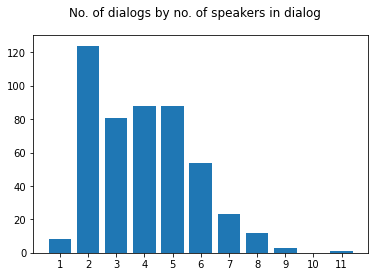

In [8]:
#No. of dialogs by no. of speakers in dialog
plot = plt.bar(len_dict.keys(),len_dict.values())
plt.xticks(range(1, len(len_dict.values())+2))
plt.suptitle("No. of dialogs by no. of speakers in dialog")

In [48]:
len_dict.most_common()

[(2, 124),
 (4, 88),
 (5, 88),
 (3, 81),
 (6, 54),
 (7, 23),
 (8, 12),
 (1, 8),
 (9, 3),
 (11, 1)]

In [6]:
pair_dialog_indices = [i for i in list(dialog_chars.keys()) if dialog_chars[i]==2]


In [7]:
all_roles = dict()
for dg in pair_dialog_indices:
    for i in range(0,len(train_df[dg][1])):
        if train_df[dg][1][i]['r'][0] not in all_roles:
            all_roles[train_df[dg][1][i]['r'][0]] = 0
        all_roles[train_df[dg][1][i]['r'][0]] += 1     

Text(0.5, 0.98, 'Relations annotated in 2-person dialogs')

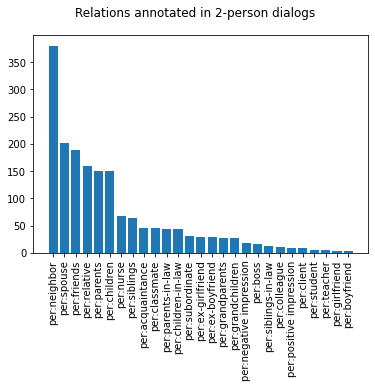

In [6]:
all_roles_list = sorted(all_roles.items(), key=lambda x:x[1],reverse=True)

ignore_relations = ['unanswerable','per:alternate_name']
all_roles_keys = [item[0] for item in all_roles_list if item[0] not in ignore_relations]
all_roles_values = [item[1] for item in all_roles_list if item[0] not in ignore_relations]

plt.xticks(rotation=90)
plt.bar(all_roles_keys,all_roles_values)

plt.suptitle("Relations annotated in 2-person dialogs")

In [97]:
all_roles_keys[0]

'unanswerable'

In [98]:
all_roles_keys[1]

'per:alternate_name'

In [91]:
sorted(all_roles.items(), key=lambda x:x[1],reverse=True)

[('unanswerable', 729),
 ('per:alternate_name', 524),
 ('per:neighbor', 380),
 ('per:spouse', 202),
 ('per:friends', 188),
 ('per:relative', 160),
 ('per:parents', 151),
 ('per:children', 151),
 ('per:nurse', 67),
 ('per:siblings', 64),
 ('per:acquaintance', 46),
 ('per:classmate', 46),
 ('per:parents-in-law', 43),
 ('per:children-in-law', 43),
 ('per:subordinate', 30),
 ('per:ex-girlfriend', 29),
 ('per:ex-boyfriend', 29),
 ('per:grandparents', 28),
 ('per:grandchildren', 28),
 ('per:negative impression', 18),
 ('per:boss', 17),
 ('per:siblings-in-law', 12),
 ('per:colleague', 10),
 ('per:positive impression', 9),
 ('per:client', 8),
 ('per:student', 6),
 ('per:teacher', 6),
 ('per:girlfriend', 4),
 ('per:boyfriend', 4)]

In [8]:
pair_dialog_df = [train_df[i] for i in pair_dialog_indices]

In [22]:
pair_dialog_df[2][1]

[{'x': 'S 1', 'y': 'S 2', 'r': ['per:parents-in-law'], 'rid': [15]},
 {'x': 'S 1', 'y': '和平', 'r': ['per:parents-in-law'], 'rid': [15]},
 {'x': 'S 2', 'y': 'S 1', 'r': ['per:children-in-law'], 'rid': [16]},
 {'x': 'S 2', 'y': '和平', 'r': ['per:alternate_name'], 'rid': [0]},
 {'x': '和平', 'y': 'S 1', 'r': ['per:children-in-law'], 'rid': [16]},
 {'x': '和平', 'y': 'S 2', 'r': ['per:alternate_name'], 'rid': [0]}]

In [29]:
pair_dialog_df[8][0]

['S 1: 喽？这是干什么呀？',
 'S 2: 志新放出来好几天了，我们想请胡伯伯跟胡伯母啊，过来吃顿饭',
 'S 1: 请他们干什么？',
 'S 2: 嗯？',
 'S 1: 志新放出来，是海南方面把问题搞清楚了嘛，他们总经理开车撞的人，他们当然要放啦，跟他胡学范有什么关系',
 'S 2: 爸，您怎么过河拆桥啊？',
 'S 1: 别人的桥，可以不拆，他的桥我还非拆不可，这个事件办成了，应该感谢政府感谢党嘛，用的着感谢胡学范嘛，都是你们，非得让我去求他',
 'S 2: 反正我们把人请来了',
 'S 1: 请来了怎么样？你看他敢来么？他怎么进来我就把他怎么扔出去！',
 'S 2: 人家来了，我看你怎么把人扔出去，我瞅瞅',
 'S 1: 你以为我不敢？我今天就让你们开开眼！哈哈老胡……']

In this example, it definitely looks like S1 is the parent-in-law, and S2 is the child-in-law, which seems consistent with the annotation order of (S2, S1). As in, <br/>
'x': 'S 1', 'y': 'S 2', 'r': ['per:parents-in-law'] means <br/>
x is the parents-in-law of y <br/>
and <br/>
'x': 'S 2', 'y': 'S 1', 'r': ['per:children-in-law'] means <br/>
x is the children-in-law of y

In [28]:
pair_dialog_df[8][1]

[{'x': 'S 1', 'y': 'S 2', 'r': ['per:parents-in-law'], 'rid': [15]},
 {'x': 'S 1', 'y': '志新', 'r': ['per:parents'], 'rid': [2]},
 {'x': 'S 1',
  'y': '胡伯伯',
  'r': ['per:neighbor', 'per:friends', 'per:colleague'],
  'rid': [13, 11, 5]},
 {'x': 'S 1', 'y': '胡伯母', 'r': ['per:friends'], 'rid': [11]},
 {'x': 'S 1',
  'y': '胡学范',
  'r': ['per:neighbor', 'per:friends', 'per:colleague'],
  'rid': [13, 11, 5]},
 {'x': 'S 1',
  'y': '老胡',
  'r': ['per:neighbor', 'per:friends', 'per:colleague'],
  'rid': [13, 11, 5]},
 {'x': 'S 2', 'y': 'S 1', 'r': ['per:children-in-law'], 'rid': [16]},
 {'x': 'S 2', 'y': '志新', 'r': ['per:relative'], 'rid': [29]},
 {'x': 'S 2', 'y': '胡伯伯', 'r': ['per:neighbor'], 'rid': [13]},
 {'x': 'S 2', 'y': '胡伯母', 'r': ['per:neighbor'], 'rid': [13]},
 {'x': 'S 2', 'y': '胡学范', 'r': ['per:neighbor'], 'rid': [13]},
 {'x': 'S 2', 'y': '老胡', 'r': ['per:neighbor'], 'rid': [13]},
 {'x': '志新', 'y': 'S 1', 'r': ['per:children'], 'rid': [1]},
 {'x': '志新', 'y': 'S 2', 'r': ['per:relati

Here, and in a few other examples, it looks like the relation annotation is in reverse order. From the dialogue, S2 says, "爸..." to S1, whereas the relation annotated is <br/>
<br/>
'x': 'S 1', 'y': 'S 2', 'r': ['per:parents-in-law'] <br/>
<br/>
These examples, as well as the diagram in [this image](https://github.com/bistu-nlp-lab/CRECIL), leads me to believe that relations are annotated as "x is the per:_relation_ of y", or "S1 is the _parents-in-law_ of S2" <br/>
<br/>
With this, I can make a dataframe with variables= _text_, _speaker-addressee-relation_

In [9]:
pair_df = []

for item in pair_dialog_df:
    

    S1_title = ''
    S2_title = ''

    for rel in item[1]:

        if rel['x']=='S 1' and rel['y']=='S 2':

            S1_title = re.findall('(?<=per:).*',rel['r'][0])
            if len(S1_title)>0: 
                S1_title=S1_title[0]

        if rel['y']=='S 1' and rel['x']=='S 2':

            S2_title = re.findall('(?<=per:).*',rel['r'][0])
            if len(S2_title)>0: 
                S2_title=S2_title[0]

        if len(S1_title)>0 and len(S2_title)>0:

            S1_relation = S1_title+":"+S2_title
            S2_relation = S2_title+":"+S1_title

            for line in item[0]:
                party = re.findall('^S\s[1-2]',line)
                if len(party)>0: 
                    party=party[0]

                    if party =='S 1':
                        pair_df.append((line,S1_relation))
                    elif party=='S 2':
                        pair_df.append((line,S2_relation))

pair_df = pd.DataFrame(list(pair_df),columns=['text','relation'])

In [9]:
Counter(pair_df.relation).most_common()

[('spouse:spouse', 9637),
 ('friends:friends', 5821),
 ('children-in-law:parents-in-law', 5705),
 ('parents-in-law:children-in-law', 5576),
 ('neighbor:neighbor', 4026),
 ('relative:relative', 2684),
 ('classmate:classmate', 2552),
 ('children:parents', 1178),
 ('parents:children', 1158),
 ('subordinate:nurse', 765),
 ('nurse:subordinate', 741),
 ('grandparents:grandchildren', 546),
 ('grandchildren:grandparents', 532),
 ('acquaintance:acquaintance', 504),
 ('siblings:siblings', 490)]

In [10]:
rel_dict = dict()
for rel in list(pair_df.relation.unique()):
    rel_dict[rel]=dict()
    rel_dict[rel]['你']=0
    rel_dict[rel]['您']=0

In [11]:
for i in range(0,len(pair_df)):
        
    rel_dict[pair_df.relation.iloc[i]]['你'] += len(re.findall('你',pair_df.text.iloc[i]))
    rel_dict[pair_df.relation.iloc[i]]['您'] += len(re.findall('您',pair_df.text.iloc[i]))

In [53]:
rel_dict

{'parents-in-law:children-in-law': {'你': 2218, '您': 4},
 'children-in-law:parents-in-law': {'你': 588, '您': 5159},
 'friends:friends': {'你': 5387, '您': 353},
 'neighbor:neighbor': {'你': 5292, '您': 79},
 'subordinate:nurse': {'你': 172, '您': 100},
 'nurse:subordinate': {'你': 422, '您': 0},
 'grandparents:grandchildren': {'你': 320, '您': 0},
 'grandchildren:grandparents': {'你': 38, '您': 275},
 'spouse:spouse': {'你': 9910, '您': 512},
 'relative:relative': {'你': 3261, '您': 283},
 'siblings:siblings': {'你': 441, '您': 0},
 'acquaintance:acquaintance': {'你': 702, '您': 135},
 'children:parents': {'你': 246, '您': 772},
 'parents:children': {'你': 1105, '您': 2},
 'classmate:classmate': {'你': 1924, '您': 140}}

In [12]:
#reverse the order of the nested keys in rel_dict
rel_dict_2 = dict()
rel_dict_2['你'] = dict()
rel_dict_2['您'] = dict()

for item in rel_dict:
    rel_dict_2['你'][item] = rel_dict[item]['你']
    rel_dict_2['您'][item] = rel_dict[item]['您']


{'你': {'parents-in-law:children-in-law': 2218,
  'children-in-law:parents-in-law': 588,
  'friends:friends': 5387,
  'neighbor:neighbor': 5292,
  'subordinate:nurse': 172,
  'nurse:subordinate': 422,
  'grandparents:grandchildren': 320,
  'grandchildren:grandparents': 38,
  'spouse:spouse': 9910,
  'relative:relative': 3261,
  'siblings:siblings': 441,
  'acquaintance:acquaintance': 702,
  'children:parents': 246,
  'parents:children': 1105,
  'classmate:classmate': 1924},
 '您': {'parents-in-law:children-in-law': 4,
  'children-in-law:parents-in-law': 5159,
  'friends:friends': 353,
  'neighbor:neighbor': 79,
  'subordinate:nurse': 100,
  'nurse:subordinate': 0,
  'grandparents:grandchildren': 0,
  'grandchildren:grandparents': 275,
  'spouse:spouse': 512,
  'relative:relative': 283,
  'siblings:siblings': 0,
  'acquaintance:acquaintance': 135,
  'children:parents': 772,
  'parents:children': 2,
  'classmate:classmate': 140}}

In [13]:
import matplotlib
print(matplotlib.matplotlib_fname())
import matplotlib.font_manager
matplotlib.font_manager.rebuild()

/home2/elyeb/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


AttributeError: module 'matplotlib.font_manager' has no attribute 'rebuild'

In [22]:
from matplotlib import font_manager

font_dirs = ["/home2/elyeb/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [24]:
import pickle

with open('rel_dict_2.pickle', 'wb') as handle:
    pickle.dump(rel_dict_2, handle, protocol=pickle.HIGHEST_PROTOCOL)



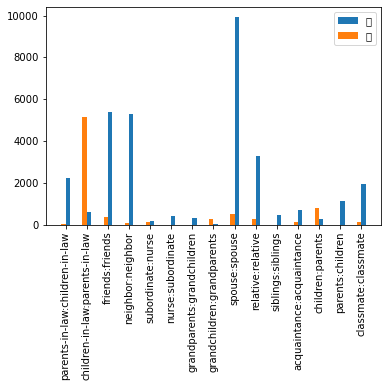

In [27]:
#try to graph the above
import matplotlib.pyplot as plt
from matplotlib import font_manager

plt.rcParams['font.sans-serif'] = ['SimHei']


fig, ax = plt.subplots()

ax.bar(rel_dict_2['你'].keys(), rel_dict_2['你'].values(), width=0.2, align='edge', label='你')
ax.bar(rel_dict_2['您'].keys(), rel_dict_2['您'].values(), width=-0.2, align='edge', label='您')


ax.legend()
plt.xticks(rotation=90)


fig.show()